In [9]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error



In [10]:
# Bước 1: Tạo dữ liệu giả định (hoặc bạn có thể sử dụng dữ liệu thực tế)
# Ví dụ: Dữ liệu hàng quý về GDP, lạm phát, và lãi suất trong 20 năm
np.random.seed(123)
n = 80  # 20 năm * 4 quý
dates = pd.date_range(start='2000-01-01', periods=n, freq='Q')
gdp = np.cumsum(np.random.normal(0.5, 1, n))  # GDP có xu hướng tăng
inflation = np.random.normal(2, 0.5, n)       # Lạm phát dao động
interest_rate = np.random.normal(5, 1, n)     # Lãi suất dao động

# Tạo DataFrame
data = pd.DataFrame({'Date': dates, 'GDP': gdp, 'Inflation': inflation, 'Interest_Rate': interest_rate})
data.set_index('Date', inplace=True)



C:\Users\NguyenHuuNghia\AppData\Local\Temp\ipykernel_2872\1017347610.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(start='2000-01-01', periods=n, freq='Q')


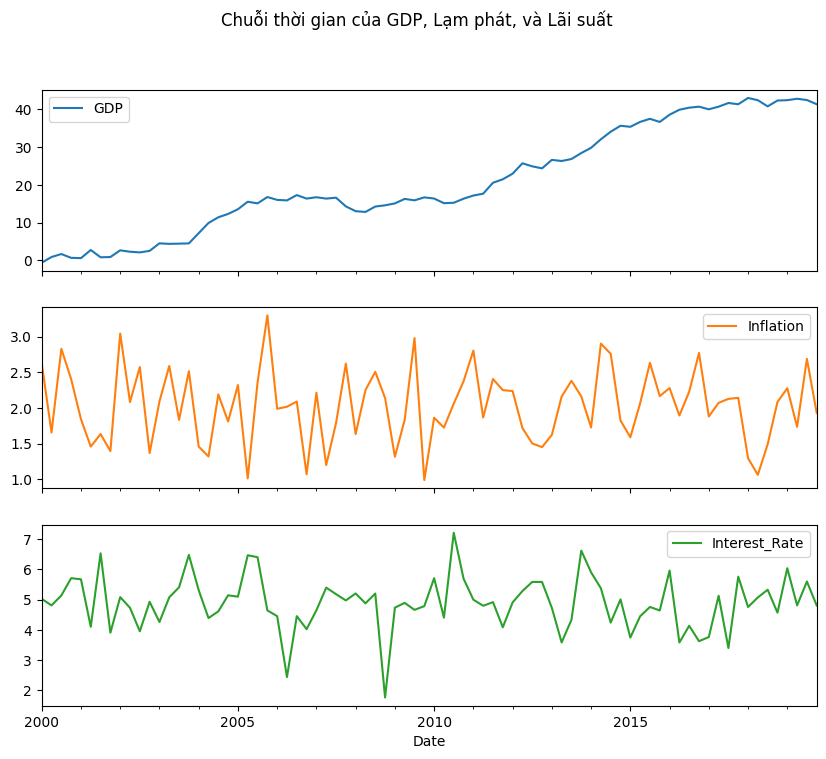

In [11]:
# Bước 2: Trực quan hóa dữ liệu
data.plot(subplots=True, figsize=(10, 8))
plt.suptitle('Chuỗi thời gian của GDP, Lạm phát, và Lãi suất')
plt.show()

In [12]:


# Bước 3: Kiểm tra tính dừng của dữ liệu
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

print("Kiểm tra tính dừng của GDP:")
check_stationarity(data['GDP'])

print("\nKiểm tra tính dừng của Lạm phát:")
check_stationarity(data['Inflation'])

print("\nKiểm tra tính dừng của Lãi suất:")
check_stationarity(data['Interest_Rate'])

# Nếu dữ liệu không dừng, lấy sai phân
data_diff = data.diff().dropna()



Kiểm tra tính dừng của GDP:
ADF Statistic: -0.5173247726815574
p-value: 0.8885911131115187
Critical Values:
   1%: -3.5159766913976376
   5%: -2.898885703483903
   10%: -2.5866935058484217

Kiểm tra tính dừng của Lạm phát:
ADF Statistic: -4.741232378818296
p-value: 7.035856383577622e-05
Critical Values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677

Kiểm tra tính dừng của Lãi suất:
ADF Statistic: -5.602432021623095
p-value: 1.2559183002109567e-06
Critical Values:
   1%: -3.5194805351545413
   5%: -2.9003945086747343
   10%: -2.5874984279778395


In [13]:
# Bước 4: Phân vùng dữ liệu
train_size = int(len(data_diff) * 0.8)
train_data = data_diff[:train_size]
test_data = data_diff[train_size:]



In [14]:
# Bước 5: Xây dựng mô hình VAR
model = VAR(train_data)
results = model.fit(maxlags=2, ic='aic')  # Chọn độ trễ tối ưu bằng AIC
print(results.summary())



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 08, Feb, 2025
Time:                     10:46:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.660526
Nobs:                     61.0000    HQIC:                  0.218630
Log likelihood:          -236.648    FPE:                   0.938829
AIC:                   -0.0661681    Det(Omega_mle):        0.677719
--------------------------------------------------------------------
Results for equation GDP
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.512637         0.193676            2.647           0.008
L1.GDP                   0.102035         0.138046            0.739           0.460
L1.Inflation            -0.231992         0.237872

c:\Users\NguyenHuuNghia\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


In [15]:
# Bước 6: Dự báo trên tập kiểm tra
lag_order = results.k_ar
forecast_input = train_data.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(test_data))
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)



In [16]:
# Bước 7: Đánh giá hiệu suất
def evaluate_forecast(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    print(f'RMSE: {rmse}')

print("Đánh giá dự báo GDP:")
evaluate_forecast(test_data['GDP'], forecast_df['GDP'])

print("\nĐánh giá dự báo Lạm phát:")
evaluate_forecast(test_data['Inflation'], forecast_df['Inflation'])

print("\nĐánh giá dự báo Lãi suất:")
evaluate_forecast(test_data['Interest_Rate'], forecast_df['Interest_Rate'])



Đánh giá dự báo GDP:
RMSE: 1.046178125598951

Đánh giá dự báo Lạm phát:
RMSE: 0.5382887136757717

Đánh giá dự báo Lãi suất:
RMSE: 1.2562342989453987


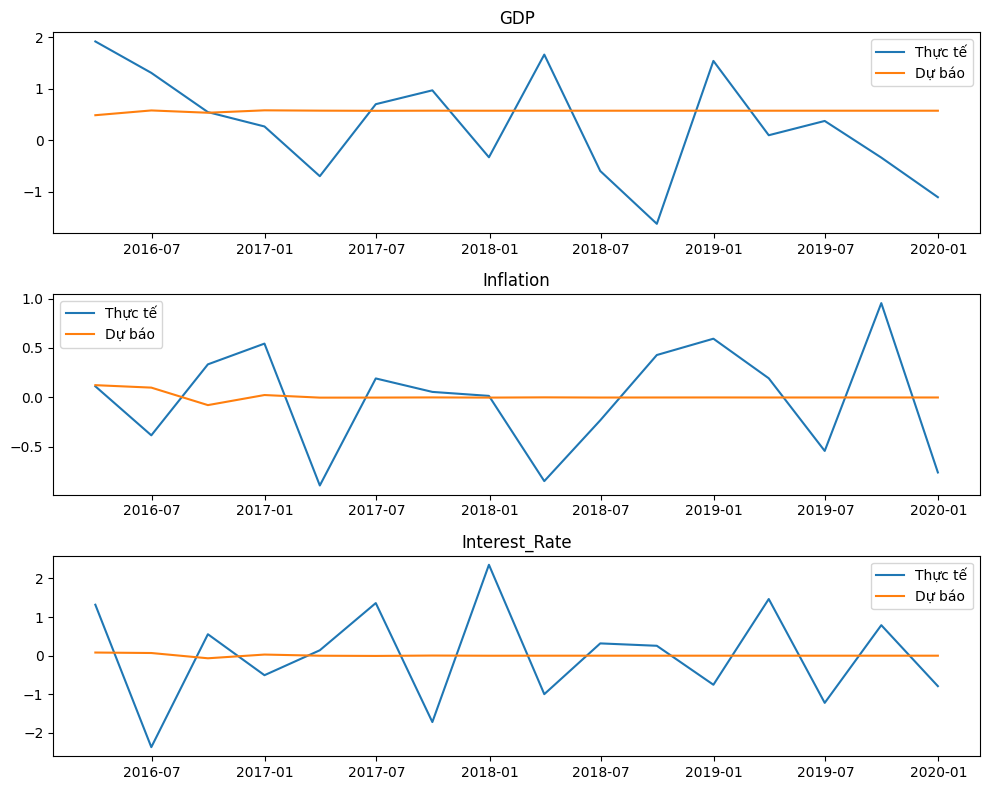

In [17]:
# Bước 8: Trực quan hóa kết quả dự báo
plt.figure(figsize=(10, 8))
for i, column in enumerate(test_data.columns):
    plt.subplot(3, 1, i+1)
    plt.plot(test_data[column], label='Thực tế')
    plt.plot(forecast_df[column], label='Dự báo')
    plt.title(column)
    plt.legend()
plt.tight_layout()
plt.show()